In [ ]:
!pip install torchmetrics -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 7.7 MB/s eta 0:00:00


In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
import os
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import tarfile
from torchvision import datasets, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch import nn
from torchvision import  transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm.auto import tqdm
import time
from tempfile import TemporaryDirectory

In [ ]:
from timeit import default_timer as timer
from torch.types import Device
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

In [ ]:
# Continue with regular imports


# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#transform for train and val data
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#Get the data

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz "
download_url(dataset_url, '.')

100%|██████████| 135107811/135107811 [00:11<00:00, 11538073.38it/s]


In [ ]:
with tarfile.open("/content/cifar10.tgz ", "r:gz") as tar:
    tar.extractall(path="./data")

In [ ]:
torch.manual_seed = 42
torch.cuda.manual_seed=42

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Download and save CIFAR-10 dataset
data_dir = "/content/data/cifar10"


# Specify train and val sizes
train_size = 45000
val_size = 5000

dataset = ImageFolder(data_dir+"/train")

# Split dataset into train and val based on specified sizes
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Apply transformations to train and val datasets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
}
# get test data
test_dir = ImageFolder(data_dir+"/test", manual_transforms)
test_dataloader = DataLoader(test_dir, batch_size=64, shuffle=False)


# Get dataset sizes and class names
dataset_sizes = {x: len(dataloader.dataset) for x, dataloader in dataloaders.items()}
class_names = dataset.classes

# Set device to cuda if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
len(test_dataloader), class_names

(157,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

#Plot and view images

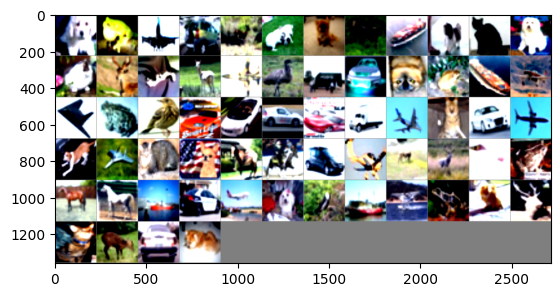

dog   frog  airplane automobile deer  dog   dog   deer  ship  dog   cat   dog   cat   deer  cat   deer  airplane bird  truck automobile dog   frog  ship  airplane airplane frog  bird  automobile automobile automobile automobile truck airplane cat   automobile airplane dog   airplane cat   dog   horse horse automobile airplane deer  deer  cat   frog  horse horse ship  automobile airplane dog   bird  ship  airplane frog  cat   deer  cat   deer  automobile dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size =64

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders["train"])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=12))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
from torchvision.utils import make_grid

def show_batch(dataloader):
  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

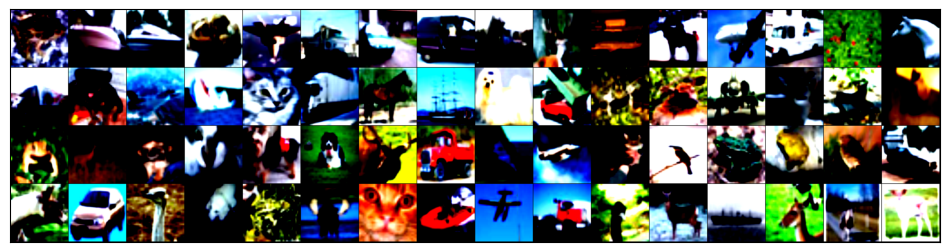

In [ ]:
show_batch(dataloaders["val"])

#**Initialize pretrained model and print the model summary**

In [ ]:
model_pretrained = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.9MB/s]


In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_pretrained,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

#**Function to train the model**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

#**Finetuning the ConvNet**

Instead of random weight initialization, we initialize the network with pretrained weights from the pretrained model.

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_ft,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5277 Acc: 0.8311
val Loss: 0.2328 Acc: 0.9224

Epoch 1/9
----------
train Loss: 0.1826 Acc: 0.9416
val Loss: 0.1829 Acc: 0.9330

Epoch 2/9
----------
train Loss: 0.1120 Acc: 0.9644
val Loss: 0.1686 Acc: 0.9434

Epoch 3/9
----------
train Loss: 0.0665 Acc: 0.9829
val Loss: 0.1623 Acc: 0.9462

Epoch 4/9
----------
train Loss: 0.0394 Acc: 0.9911
val Loss: 0.1701 Acc: 0.9438

Epoch 5/9
----------
train Loss: 0.0245 Acc: 0.9957
val Loss: 0.1740 Acc: 0.9474

Epoch 6/9
----------
train Loss: 0.0172 Acc: 0.9980
val Loss: 0.1729 Acc: 0.9470

Epoch 7/9
----------
train Loss: 0.0114 Acc: 0.9990
val Loss: 0.1716 Acc: 0.9476

Epoch 8/9
----------
train Loss: 0.0101 Acc: 0.9992
val Loss: 0.1720 Acc: 0.9478

Epoch 9/9
----------
train Loss: 0.0097 Acc: 0.9993
val Loss: 0.1750 Acc: 0.9470

Training complete in 36m 26s
Best val Acc: 0.947800


In [ ]:
PATH = './cifar_net.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc, correct = 0, 0, 0
    model.eval()  # Use the provided model argument instead of cnn_model
    with torch.inference_mode():
        for i, data in enumerate(data_loader):
          X, y = data[0].to(device), data[1].to(device)
          # Make predictions
          y_pred = model(X)  # Use the provided model argument

          # Accumulate the loss and acc values per batch
          loss += loss_fn(y_pred, y)
          acc += accuracy_fn(y_true=y,
                            y_pred=y_pred.argmax(dim=1))
          correct += torch.eq(y, y_pred.argmax(dim=1)).sum().item()

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"corret_predictions": correct,
            "model_loss": loss.item(),
            "model_acc": acc}  # Convert to item

# Calculate model results on test dataset
model_results = eval_model(model=model_ft,
                            data_loader=test_dataloader,
                            loss_fn=criterion,
                            accuracy_fn=accuracy_fn)
model_results


{'corret_predictions': 9488,
 'model_loss': 0.16914838552474976,
 'model_acc': 94.87460191082802}

In [ ]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(data_dir+"/test").glob("*/*.png"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
      pred_dict["pred_label"] = pred_label.item()

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_ft,
                                 transform=manual_transforms,
                                 class_names=class_names,
                                 device=device)



  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
test_pred_dicts[:1]

[{'image_path': PosixPath('/content/data/cifar10/test/automobile/0504.png'),
  'class_name': 'automobile',
  'pred_prob': 0.9999690055847168,
  'pred_class': 'automobile',
  'pred_label': 1,
  'correct': True},
 {'image_path': PosixPath('/content/data/cifar10/test/automobile/0921.png'),
  'class_name': 'automobile',
  'pred_prob': 0.9999964237213135,
  'pred_class': 'automobile',
  'pred_label': 1,
  'correct': True}]

In [ ]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)

In [ ]:
correct_preds = test_pred_df[test_pred_df["correct"]==True]

In [ ]:
correct_preds.head()

,image_path,class_name,pred_prob,pred_class,pred_label,correct
0,/content/data/cifar10/test/automobile/0504.png,automobile,0.999969,automobile,1,True
1,/content/data/cifar10/test/automobile/0921.png,automobile,0.999996,automobile,1,True
2,/content/data/cifar10/test/automobile/0666.png,automobile,0.999988,automobile,1,True
3,/content/data/cifar10/test/automobile/0311.png,automobile,0.629633,automobile,1,True
4,/content/data/cifar10/test/automobile/0557.png,automobile,0.998993,automobile,1,True


In [ ]:
correct_pred_img = list(correct_preds["image_path"])
len(correct_pred_img)

9488

In [ ]:
correct_pred_class = list(correct_preds["class_name"])
correct_pred_labels = list(correct_preds["pred_label"])

In [ ]:
from shutil import copy
from collections import defaultdict
import os

In [ ]:
correct_pred_img = [str(path) for path in correct_pred_img]

# Create a defaultdict to store lists of file paths for each category
category_lists = defaultdict(lambda: [])

# Loop through the file paths and categorize them
for file_path in correct_pred_img:
    # Split the file path using '/'
    parts = file_path.split('/')
    # The category is the second-to-last part of the path
    category = parts[-2]
    # Append the file path to the corresponding category list
    category_lists[category].append(file_path)

output_dir = '/content/data/cifar10/correct_test/'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create a folder for each category and copy the images with category name in the filename
for category, paths in category_lists.items():
    category_dir = os.path.join(output_dir, category)
    os.makedirs(category_dir, exist_ok=True)
    for path in paths:
        # Get the filename from the path
        filename = os.path.basename(path)
        # Modify the filename to include the category name
        new_filename = f"{category}_{filename}"
        # Copy the image to the category folder with the new filename
        copy(path, os.path.join(category_dir, new_filename))

print("Folders created and images organized.")

Folders created and images organized.


In [ ]:
correct_test_dir = ImageFolder(data_dir+"/correct_test", manual_transforms)
correct_test_dataloader = DataLoader(correct_test_dir, batch_size=64, shuffle=False)

In [ ]:
len(correct_test_dataloader)

149

In [ ]:
pred_labels = get_all_preds(model=model_ft, loss_fn=criterion, dataloader=correct_test_dataloader, device=device)

In [ ]:
pred_labels["model_result"]

{'model_loss': 0.026152778416872025,
 'model_acc': 100.0,
 'correct_predictions': 9504,
 'wrong_predictions': 0}

#**Evaluate the model performance on the test data**

#**Data Augmentation:**
##**Transform the data and test the model's performance on the transformed data**


#####**Define a custom transformation to add Gaussian noise**

In [168]:
import numpy as np
from PIL import Image

class AddGaussianNoise:
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_np = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_np.shape)
            noisy_img = np.clip(img_np + noise, 0, 255).astype(np.uint8)
            return Image.fromarray(noisy_img)
        return img

#####**Initializing other Augmentation Transformations**

In [169]:
data_transforms = {
    'colorjitter': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'random_perspective': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.8),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'random_affine': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(degrees=0, shear=20),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'random_rotation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'Gaussian_Noise' : transforms.Compose([
        transforms.Resize((224, 224)),
        AddGaussianNoise(mean=0, std=25, p=0.5),  # Add Gaussian noise with mean 0, std 25, probability 0.5
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ]),
    'actual_test_data': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])
}




##**Get and transform the data**




In [171]:
torch.manual_seed = 42
torch.cuda.manual_seed = 42


correct_test_dir = {x: ImageFolder(data_dir+"/correct_test", transform=data_transforms[x])
                    for x in ['actual_test_data','colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}

correct_test_dataloader = {x: DataLoader(correct_test_dir[x], batch_size=64, shuffle=False)
                           for x in ['actual_test_data','colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}

# aug_test_dir = {x:datasets.CIFAR10(data_dir, train=False, download=True, transform=data_transforms[x])
#                   for x in ['actual_test_data','colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}

# aug_test_dataloader = {x:DataLoader(aug_test_dir[x], batch_size=64, shuffle=False)
#                   for x in ['actual_test_data','colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}


In [174]:
len(correct_test_dataloader["actual_test_data"])

149

###**Plot and view the augmented data**

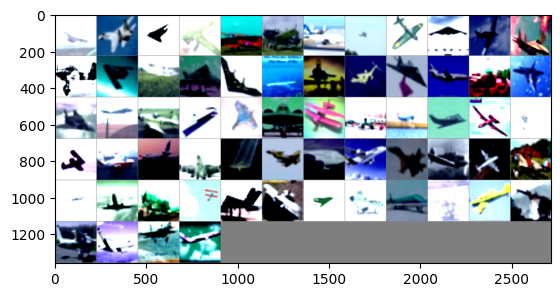

airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane airplane


In [176]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size =64

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(correct_test_dataloader["colorjitter"])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images, nrow=12))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

#**Evaluate and make predictions on the augmented data**

In [177]:
def get_all_preds(model, dataloader, loss_fn: torch.nn.Module, device: torch.device = device):
    pred_probs = []
    labels_list = []  # Create a list to store labels
    model.to(device)
    loss, acc, correct, wrong = 0, 0, 0, 0

    model.eval()

    with torch.no_grad():  # Using no_grad context to avoid unnecessary gradient calculations
        for batch in dataloader:
            images, batch_labels = batch  # Use a different variable name for the labels
            images, batch_labels = images.to(device), batch_labels.to(device)

            pred_logit = model(images)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = pred_logit.argmax(dim=1)

            # Get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob)
            labels_list.append(batch_labels)  # Store the labels in a list

            loss += loss_fn(pred_logit, batch_labels)  # Use batch_labels for loss calculation
            acc += accuracy_fn(y_true=batch_labels, y_pred=pred_prob)
            correct += torch.eq(batch_labels, pred_prob).sum().item()
            wrong += (batch_labels != pred_prob).sum().item()




        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(dataloader)
        acc /= len(dataloader)



    # Convert to item
    pred_probs = torch.cat(pred_probs, dim=0)
    labels = torch.cat(labels_list, dim=0)
    correct += torch.eq(batch_labels, pred_prob).sum().item()
    wrong += (batch_labels != pred_prob).sum().item()  # Concatenate the list of labels into a tensor
    return {
        "pred_probs": pred_probs,
        "labels":labels,
        "model_result":{"model_loss": loss.item(),
                        "model_acc": acc,
                        "correct_predictions": correct,
                        "wrong_predictions": wrong}
          }





#####**Prediction for unaugmented (actual test data) and Augmented data**

In [178]:
pred_labels = {x: get_all_preds(model=model_ft, loss_fn=criterion, dataloader=correct_test_dataloader[x], device=device)
               for x in ['actual_test_data','colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}

#####**Model Accuracy for unaugmented (actual test data) and Augmented data**

---



In [179]:

data_accuracy = {x: accuracy_fn(y_true=pred_labels[x]["labels"], y_pred=pred_labels[x]["pred_probs"])
                for x in ['actual_test_data','colorjitter', 'random_perspective', 'random_affine', 'random_rotation','Gaussian_Noise']}


In [180]:
data_accuracy["actual_test_data"]

100.0

In [181]:
pred_labels["Gaussian_Noise"]

{'pred_probs': tensor([8, 4, 0,  ..., 6, 9, 9], device='cuda:0'),
 'labels': tensor([0, 0, 0,  ..., 9, 9, 9], device='cuda:0'),
 'model_result': {'model_loss': 0.8716671466827393,
  'model_acc': 78.22986577181209,
  'correct_predictions': 7440,
  'wrong_predictions': 2064}}

###**Compare actual test data accuracy and Augmented data accuracy**

In [182]:
import pandas as pd

data_accuracies = [
    pred_labels["actual_test_data"]["model_result"],
    pred_labels["colorjitter"]["model_result"],
    pred_labels["random_perspective"]["model_result"],
    pred_labels["random_affine"]["model_result"],
    pred_labels["random_rotation"]["model_result"],
    pred_labels["Gaussian_Noise"]["model_result"]
]

index = ['actual_test_data', 'colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']
columns = data_accuracies[0].keys()  # Assuming model_results is a dictionary containing keys for the columns

df = pd.DataFrame(data_accuracies, index=index, columns=columns)

df


,model_loss,model_acc,correct_predictions,wrong_predictions
actual_test_data,0.026153,100.000000,9504,0
colorjitter,0.267121,91.652685,8712,792
random_perspective,0.433409,86.776426,8251,1253
random_affine,0.279097,91.149329,8664,840
random_rotation,0.403267,87.447567,8309,1195
Gaussian_Noise,0.871667,78.229866,7440,2064


##**Compute Confusion Metrix**

In [183]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

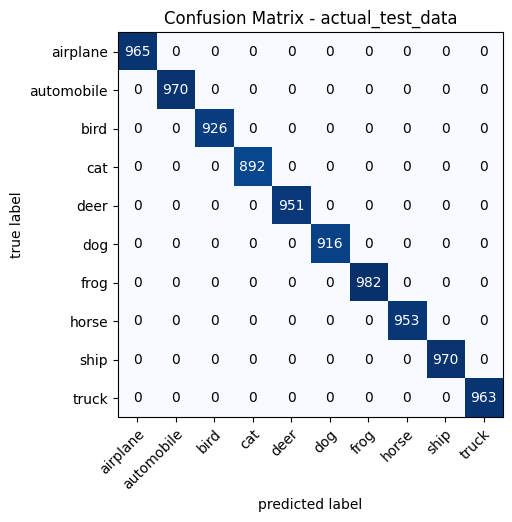

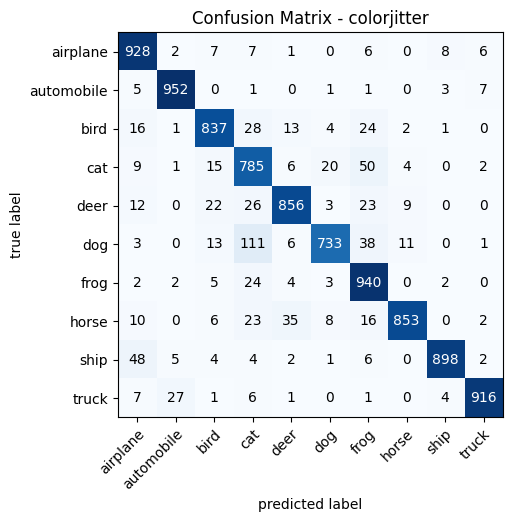

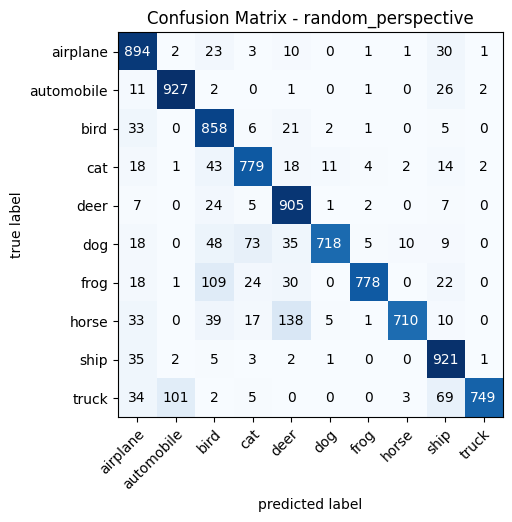

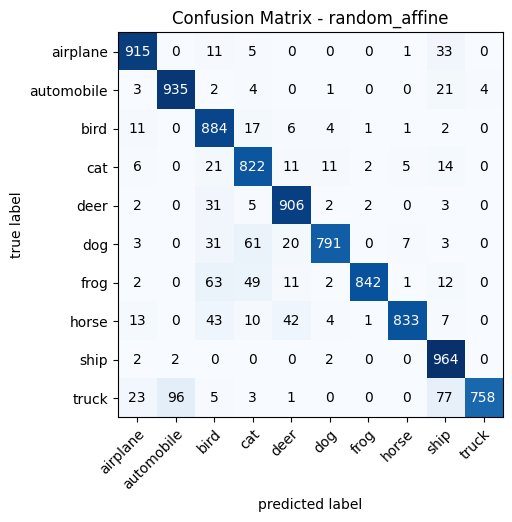

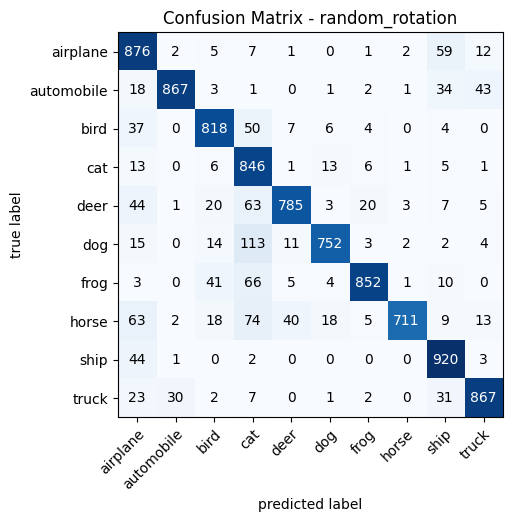

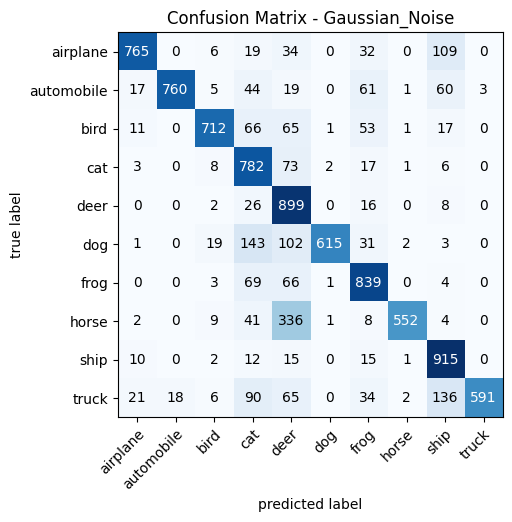

In [184]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="MULTICLASS").to(device)
confmat_tensor = {x: confmat(preds=pred_labels[x]["pred_probs"], target=pred_labels[x]["labels"])
                  for x in ['actual_test_data','colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']}




for x in ['actual_test_data','colorjitter', 'random_perspective', 'random_affine', 'random_rotation', 'Gaussian_Noise']:
  fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor[x].cpu().numpy(),
    class_names=class_names,
    figsize=(5, 5)
  )
  ax.set_title(f'Confusion Matrix - {x}')

#**Compare Wrong predictions from actial test data (unaugmented data) and the augmented data**

####This is done to identify and eliminate the original model errors.

In [185]:
import pandas as pd

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_classwise_predictions(pred_probs, labels):
    classwise_correct = [0] * len(class_name)
    classwise_wrong = [0] * len(class_name)

    for i in range(len(labels)):
        true_label = labels[i].item()
        pred_label = pred_probs[i].item()

        if true_label == pred_label:
            classwise_correct[true_label] += 1
        else:
            classwise_wrong[true_label] += 1

    return classwise_correct, classwise_wrong

classwise_results = {}

for augmentation_type, pred_label in pred_labels.items():
    classwise_correct, classwise_wrong = get_classwise_predictions(pred_label['pred_probs'], pred_label['labels'])

    classwise_results[augmentation_type] = {
        "correct": classwise_correct,
        "wrong": classwise_wrong
    }

# Create a DataFrame from the classwise_results dictionary
df = pd.DataFrame(
    {class_name[i]: [classwise_results[aug_type]["wrong"][i] for aug_type in pred_labels.keys()] for i in range(len(class_name))},
    index=pred_labels.keys()
)

df


,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
actual_test_data,0,0,0,0,0,0,0,0,0,0
colorjitter,37,18,89,107,95,183,42,100,72,47
random_perspective,71,43,68,113,46,198,204,243,49,214
random_affine,50,35,42,70,45,125,140,120,6,205
random_rotation,89,103,108,46,166,164,130,242,50,96
Gaussian_Noise,200,210,214,110,52,301,143,401,55,372
